**Full Name:**

**Student Number:**


# Convolutional Neural Networks
I this notebook, you'll get familiar with the implementation of CNNs by building and training two CNN networks.

## Preparing the Data
For this taks, you're going to use the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. CIFAR10 is a collection of 32 * 32 images in 10 classes. Each image in CIFAR10 has three channels (RGB). You are going to download and prepare the dataset manually.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from torchvision.io import read_image

**For this question, it's highly recommended to use a CUDA-enabled environment.**
We'll check for the availability of GPU and set `device` accordingly.

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

In [4]:
device

device(type='cuda')

In [3]:
url = "http://dl.dropboxusercontent.com/s/dywydpafhaamquw/cifar10.zip"
# Download the dataset using Torchvision's  `download_url`
#############################
# Your code goes here (1 point)
download_url(url, ".") 
#############################
!unzip -qq "./cifar10.zip"

100%|██████████| 145997066/145997066 [00:03<00:00, 38026407.02it/s]


Now you are going to implement a custom dataset class for the data you've downloaded. You can implement a custom dataset by inheriting from PyTorch's `Dataset` class. You'll then have to override `__init__`, `__len__`, and `__getitem__` functinos in your custom class. One of the advantages of defining a custom dataset like this is that you have complete control over the data that the dataset returns.

The the dataset you've downloaded has the following structure:
```
cifar10/
    test/
        img_file1.png
        img_file2.png
        ..
        ..
        annotation.csv
    train/
        img_file1.png
        img_file2.png
        ...
        ...
        annotation.csv
```

The `annotation.csv` file in each directory contains a complete list of file names and labels for all the image files in that directory. **Keep in mind that the csv files provided have no header information**.

In [5]:
class CustomCifarDataset(Dataset):
    def __init__(self, annotations_file, root_dir, transform=None):
        """
        `annotation_file`: Path to the csv file with annotations.
        `root_dir`: Directory with all the images.
        `transform`: Transform to be applied.
        """
        self.root_dir = root_dir
        self.transform = transform
        # Read the csv annotation file using pandas' `read_csv` function.
        # (The annotation file consists of n rows. Each row is in the format 
        #    img_file_name, img_label
        #  For example:
        #    airplane_1001, 0
        # )
        #############################
        # Your code goes here (2 points)
        self.annotations = pd.read_csv(annotations_file)
        #############################

    def __len__(self):
        # Return the number of data points
        #############################
        # Your code goes here (1 point)
        return len(self.annotations)
        #############################

    def __getitem__(self, idx):
        """
        idx: index of the data point referenced.
        """
        # Use `idx` to index the annotation file you parsed in `__init__`.
        # Using `read_image`, load the corresponding image from the disk.
        # Normalize the data to be between 0 and 1.
        # Apply transformation(s) to the image and return the transformed 
        # image and its label.
        #############################
        # Your code goes here (7 points)
        
        # Construct the full path to the image
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        # Open the image file
        image = Image.open(img_path)
        # Get the label for the current image
        label = self.annotations.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
        #############################

In [6]:
test_set = CustomCifarDataset("./cifar10/test/annotation.csv", "./cifar10/test/", ToTensor())
train_set = CustomCifarDataset("./cifar10/train/annotation.csv", "./cifar10/train/", ToTensor())

In [7]:
# Split your training set into train and validation sets (8:2 ratio).
#############################
# Your code goes here (2 points)

train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])
#############################

len(train_set), len(val_set), len(test_set)

(39999, 10000, 9999)

In [8]:
# Construct three `DataLoader`s for validation, training, and test sets.
# Use a batch size of 128.
# No shuffling.
#############################
# Your code goes here (5 points)
batch_size = 128 
train_dataloader = DataLoader(train_set, batch_size=batch_size,  shuffle=False)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
#############################

In [9]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # Compute model's ouptut
            # Move your data to GPU if it's available
            ##############################
            # Your code goes here (5 points)
            X, y = imgs.to(device), labels.to(device)
            ##############################
            # Compute prediction error
            pred = model(X)

            # Compute the loss.
            ##############################
            # Your code goes here (7 points)
            loss = loss_fn(pred, y) 

            ##############################

            # Do the backprop step.
            ##############################
            # Your code goes here (2 points)
    
            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            ##############################
            
            loss_train += loss.item()

        validation_loss = validate(model, val_loader, loss_fn)
        print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, loss_train / len(train_loader), validation_loss))


In [15]:
def validate(model, val_loader, loss_fn):
        with torch.no_grad():
            val_loss = 0.0
            for imgs, labels in val_loader:
                # Compute the loss
                ##############################
                # Your code goes here (9 points)
                X, y = imgs.to(device), labels.to(device)
                
                pred = model(X)
                loss = loss_fn(pred, y) 
                ##############################
                val_loss += loss.item()

        return val_loss / len(val_loader)

In [16]:
def test(model, test_loader):
  model.eval()
  correct = 0
  size = len(test_loader.dataset)

  with torch.no_grad():
    for imgs, labels in test_loader:
      # Compute the predicted class and update 
      # `total` and `correct` accordingly
      ##############################  
      # Your code goes here (9 points)
        X, y = imgs.to(device), labels.to(device)
        pred = model(X)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    return correct / size

## Creating the Model
Now you're going to build the CNN model. The overall architecture of the model you are going to implement is depicted in the following picture (All of the max poolings used have a stride of 2*2):

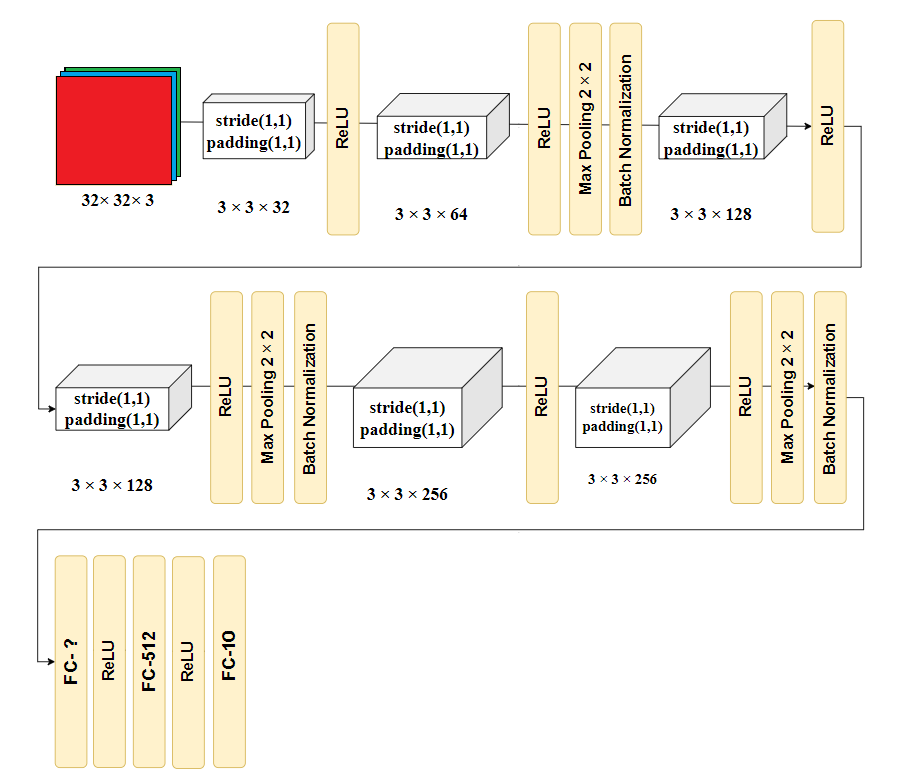

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, out_dim):
        """
        `in_channels`: Number of channels for input instances
        `out_dim`    : The network's output dimensions
        """
        super().__init__()
        self.relu = nn.ReLU()            # Apply for all the layers (except the last one)
        self.maxpool = nn.MaxPool2d(2,2) # Apply for conv2, conv4, and conv6
        
        self.bn1 = nn.BatchNorm2d(64) # Apply for conv2
        self.bn2 = nn.BatchNorm2d(128) # Apply for conv4
        self.bn3 = nn.BatchNorm2d(256) # Apply for conv6
        
        self.conv1 = self.conv2 = self.conv3 = self.conv4 = self.conv5 = self.conv6 = None
        self.fc1 = self.fc2 = self.fc3 = None

        
        # Create five 2D convolutional layers (conv1 through conv6)
        # Set the padding and stride to 1 for all the layers.
        # Use 3*3 kernels.
        ##############################
        # Your code goes here (10 points)
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1)

        ##############################

        self.flatten = nn.Flatten(start_dim=1)
        
        # According to the output dimensions of `conv6` and the `in_features` value for fc2,
        # set `in_features` and `out_features` for fc1 to proper values. 
        ##############################
        # your code goes here (5 points)
    
        self.fc1 = nn.Linear(4096, 1024)
        #############################
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, out_dim)
        
    def forward(self, x):
        # Move x thorugh the network and return the output
        # according to the architecture.
        ##############################
        # Your code goes here (10 points)
        
        x = self.conv1(x) 
        x = self.relu(x) 
        
        x = self.conv2(x) 
        x = self.relu(x)
        x = self.maxpool(x) 
        x = self.bn1(x) 
        
        x = self.conv3(x)
        x = self.relu(x) 

        x = self.conv4(x)
        x = self.relu(x) 
        x = self.maxpool(x) 
        x = self.bn2(x) 

        x = self.conv5(x) 
        x = self.relu(x) 
        
        x = self.conv6(x) 
        x = self.maxpool(x) 
        x = self.bn3(x)  
        
        x = self.flatten(x) 
        
        x = self.fc1(x) 
        x = self.fc2(x) 
        x = self.fc3(x) 

        ##############################
        return x

In [18]:
model = SimpleCNN(3, 10).to(device=device)
model

SimpleCNN(
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out

In [19]:
# Use Adam optimizer with a learning rate of 0.001 as the optimizer.
# Use CrossEntropy as loss function.
##############################
# Your code goes here (5 points)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
##############################
train(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_dataloader,
    val_loader=val_dataloader
)

Epoch 1, Training loss 1.4821277079871669, Validation loss 1.0944993503486053
Epoch 2, Training loss 0.9220990110129214, Validation loss 0.8708924786953987
Epoch 3, Training loss 0.7052922240270975, Validation loss 0.7798579222039331
Epoch 4, Training loss 0.5605290739681013, Validation loss 0.7636335394050502
Epoch 5, Training loss 0.4433842568923109, Validation loss 0.8745029153703134
Epoch 6, Training loss 0.3494075971860855, Validation loss 0.9463049286528479
Epoch 7, Training loss 0.28575482381323275, Validation loss 1.0132301751571366
Epoch 8, Training loss 0.2346962515633708, Validation loss 1.067109018941469
Epoch 9, Training loss 0.17822689610048414, Validation loss 1.1166268836093853
Epoch 10, Training loss 0.12529606706560992, Validation loss 1.1491680088676983


In [20]:
test(model, test_dataloader)

0.7817781778177818

## Visualizing Feature Maps

The feature maps, also known as activation maps, record what happens when the filters are applied to an input.


In this section, you're going to visualize feature maps for a random input image for layers `conv1` through `conv6`. 

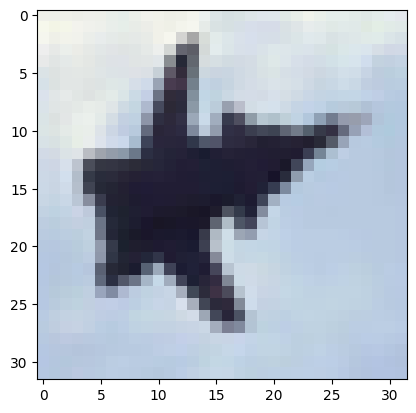

In [23]:
import random
img = train_set[random.randint(0, len(train_set))][0]
plt.imshow(img.permute(1,2,0))
plt.show()

In [27]:
conv_layers = [model.conv1, model.conv2, model.conv3, model.conv4, model.conv5, model.conv6]

# Pass `img` thorough the layers and save the results for each layer in `output`.
##############################
# Your code goes here (5 points)

outputs = [] 
input_ = img.to(device)
for conv_layer in conv_layers: 
    input_ = conv_layer(input_)
    outputs += [input_]
    
##############################
len(outputs)

6

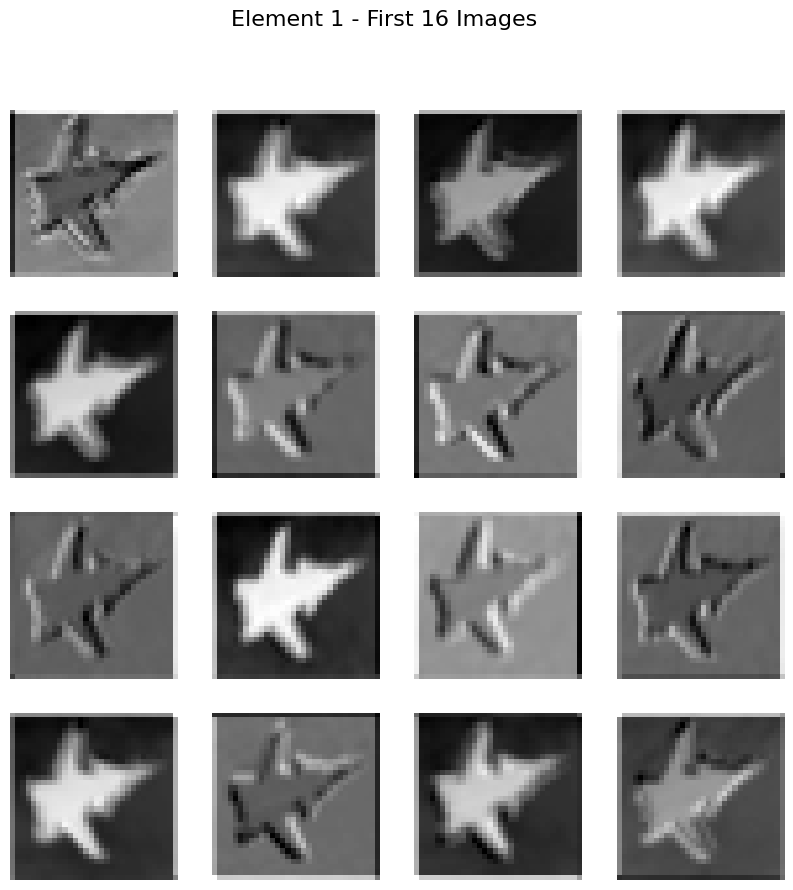

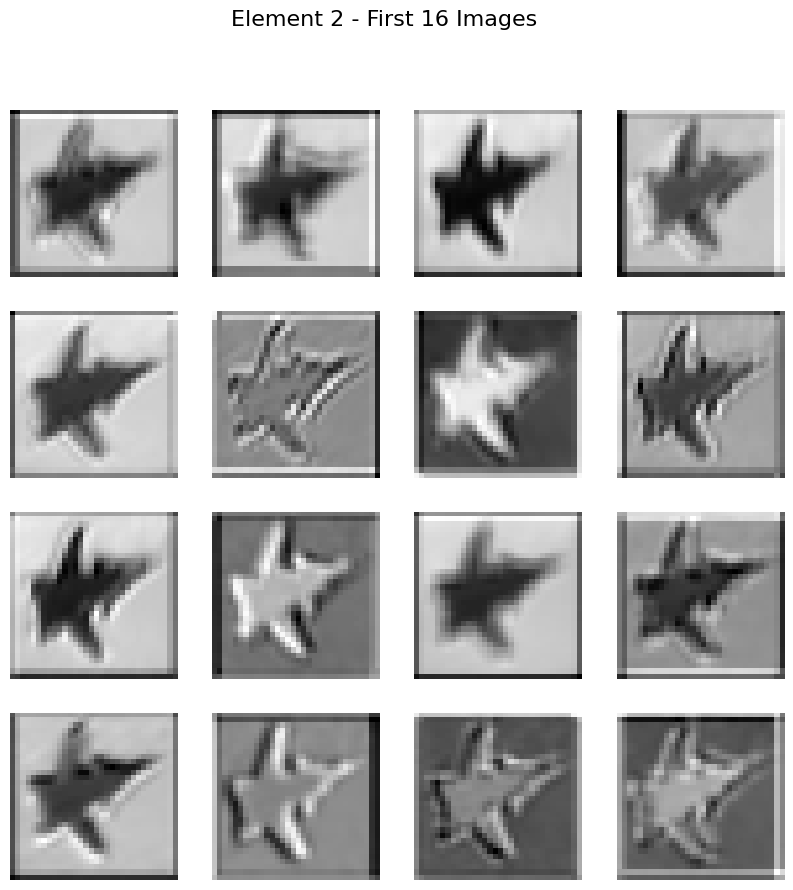

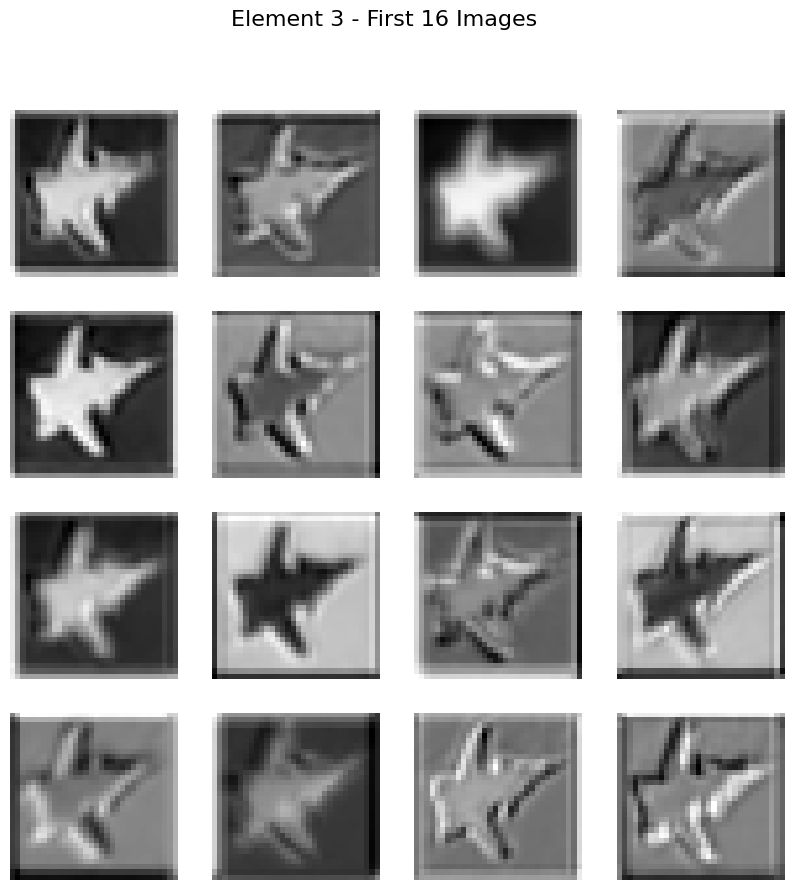

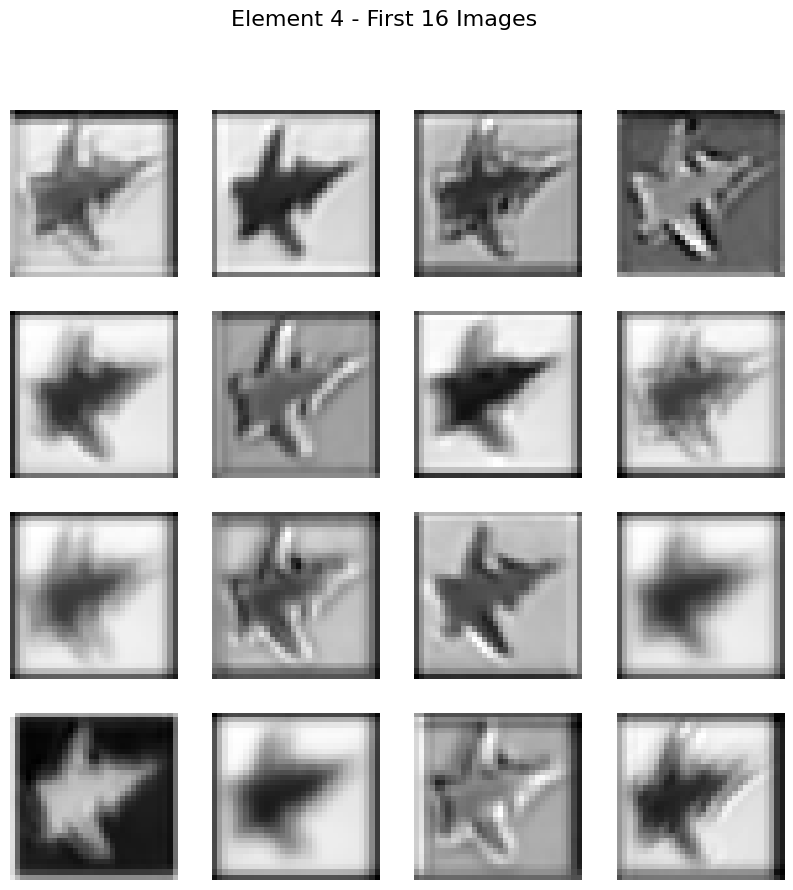

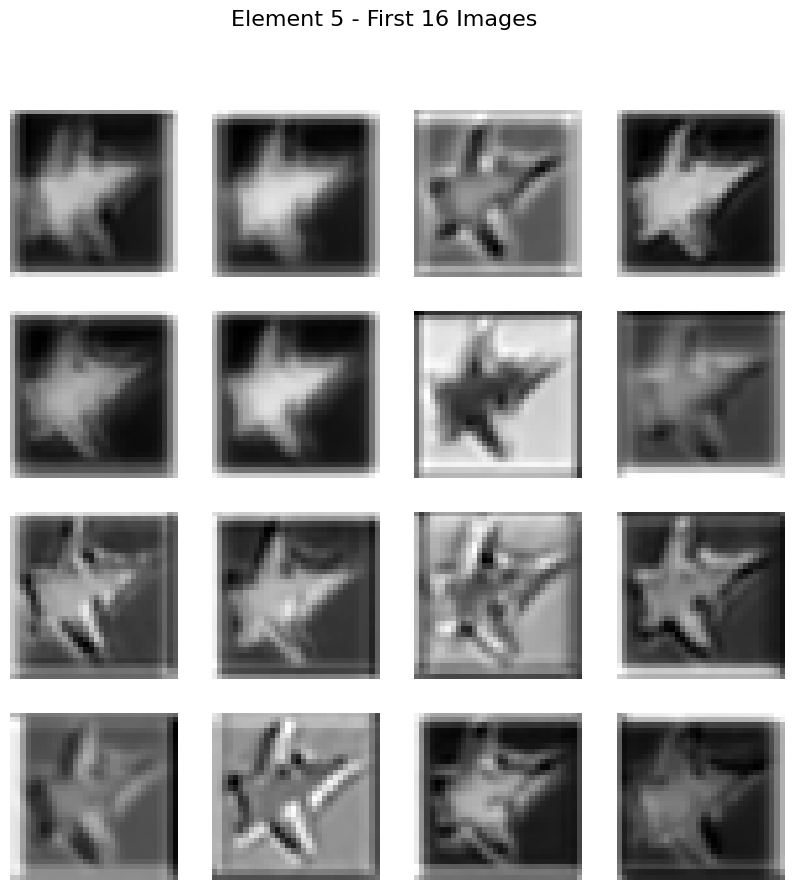

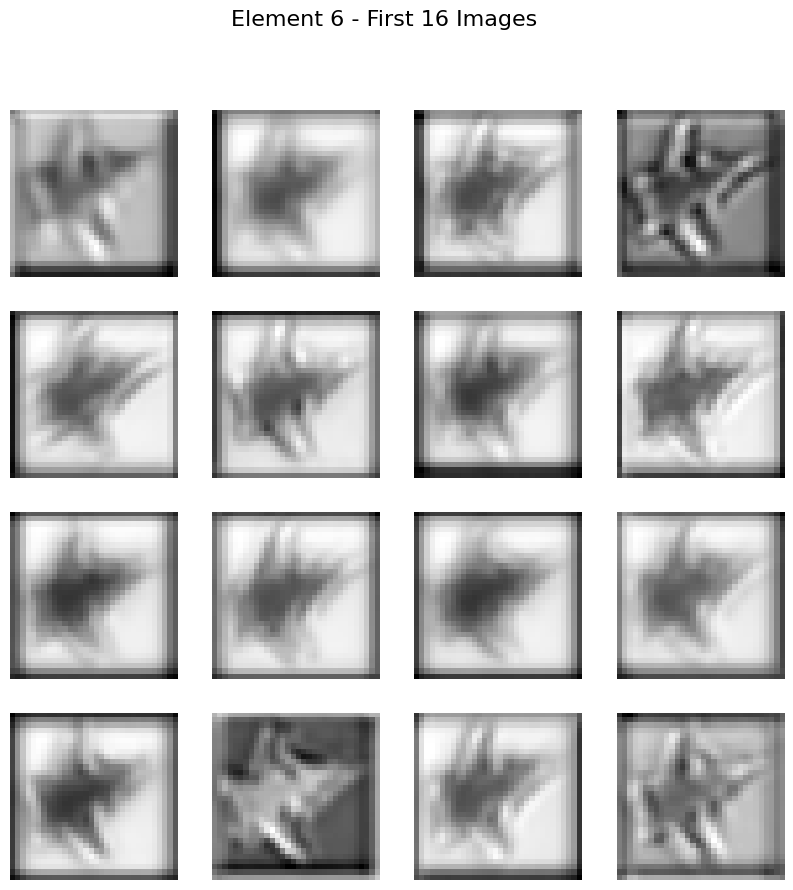

In [30]:
# Visualize the output for the first 16 filters of each layer.
##############################
# Your code goes here (5 points)

def plot_images_from_list(images_list, title="Images"):
    """Plot the first 16 images from a list of images."""
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < len(images_list):
            ax.imshow(images_list[i].cpu().detach().numpy(), cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off') # Hide axis if no more images
    plt.show()

# Loop through each element in the array and plot the first 16 images
for index, images in enumerate(outputs):
    plot_images_from_list(images[:16], title=f"Element {index+1} - First 16 Images")

##############################

**Answer the following question (5 points):**
- Which one of the feature maps you visualized do you find helpful for the task? Which ones you don't find helpful?

[tensor([[[ 0.0925,  0.2820,  0.2796,  ...,  0.2955,  0.2969,  0.2140],
          [-0.0509,  0.0814,  0.0784,  ...,  0.0909,  0.0988,  0.1530],
          [-0.0478,  0.0841,  0.0843,  ...,  0.1077,  0.0999,  0.1587],
          ...,
          [ 0.0019,  0.1393,  0.1328,  ...,  0.1457,  0.1450,  0.1884],
          [ 0.0018,  0.1416,  0.1363,  ...,  0.1431,  0.1482,  0.1929],
          [ 0.0968,  0.1736,  0.1756,  ...,  0.1750,  0.1753, -0.0234]],
 
         [[-0.0917, -0.3100, -0.3065,  ..., -0.2904, -0.2928,  0.0588],
          [-0.4867, -0.9576, -0.9469,  ..., -0.8980, -0.9032, -0.2853],
          [-0.4945, -0.9781, -0.9584,  ..., -0.9006, -0.9055, -0.2930],
          ...,
          [-0.3438, -0.7666, -0.7565,  ..., -0.7688, -0.7652, -0.2500],
          [-0.3382, -0.7551, -0.7505,  ..., -0.7515, -0.7503, -0.2415],
          [-0.2998, -0.7893, -0.7931,  ..., -0.7718, -0.7717, -0.3652]],
 
         [[ 0.3529, -0.0845, -0.0756,  ..., -0.0528, -0.0588, -0.2794],
          [-0.5810, -1.0225,